<a href="https://colab.research.google.com/github/chemicoPy/MACD-RSI-STOCHASTIC-strategy/blob/ccxt/MACD_RSI_STOCHASTIC_strategy_(ccxt).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ccxt
!pip install pandas_ta
!pip install schedule

     |████████████████████████████████| 2.3 MB 5.4 MB/s 
     |████████████████████████████████| 271 kB 69.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 
     |████████████████████████████████| 3.6 MB 45.3 MB/s 
     |████████████████████████████████| 160 kB 47.5 MB/s 
     |████████████████████████████████| 291 kB 60.3 MB/s 
     |████████████████████████████████| 192 kB 62.8 MB/s 
     |████████████████████████████████| 115 kB 5.4 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=8b7a971fcba8bf2ce9869941d22e0d35b68d15e1233ca1b791bfd55b285686d5
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [2]:
import ccxt
import pandas as pd
import numpy as np
from numpy import *
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from IPython.display import clear_output
import schedule


In [3]:

API_KEY = ""
API_SECRET = ""

In [4]:
""" Examples_of_coins_are = ["BNBUSDT", "ETHUSDT", "ADAUSDT", "DOTUSDT", "BTCUSDT", "FTMUSDT", "DOGEUSDT", "LINKUSDT", "SUSHIUSDT", "SOLUSDT",
                 "IOSTUSDT", "LTCUSDT", "XRPUSDT", "SXPUSDT", "MATICUSDT", "BCHUSDT"] """

coin = str(input("Enter coin name: ").upper())
interval = str(input("Enter time interval name e.g 5m for 5-minute: ").lower())

""" For example:
coin = 'BTCUSDT'
interval = '1m' """


Enter coin name: btcusdt
Enter time interval name e.g 5m for 5-minute: 1m


" For example:\ncoin = 'BTCUSDT'\ninterval = '1m' "

In [5]:
""" Code line to see all columns of that data grabbed """
exchangepub = ccxt.binanceus()   # You can choose/enter the ID you prefer here e.g binance, coinbase, coinmate, coinmetro e.t.c

exchange_id = 'binanceus'
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': API_KEY,
    'secret': API_SECRET,
    'timeout': 3333,
    'enableRateLimit': True,
})

index = coin.find('USDT')
symbol = coin[:index] + '/' + coin[index:]

instrument = exchange.fetchTickers(str(symbol))
print((instrument))

{'BTC/USD': {'symbol': 'BTC/USD', 'timestamp': 1642342111856, 'datetime': '2022-01-16T14:08:31.856Z', 'high': 43828.92, 'low': 42602.14, 'bid': 43281.13, 'bidVolume': 0.567, 'ask': 43295.85, 'askVolume': 0.405, 'vwap': 43234.1892, 'open': 42934.91, 'close': 43301.37, 'last': 43301.37, 'previousClose': 42920.11, 'change': 366.46, 'percentage': 0.854, 'average': 43118.14, 'baseVolume': 518.874498, 'quoteVolume': 22433118.2425, 'info': {'symbol': 'BTCUSD', 'priceChange': '366.4600', 'priceChangePercent': '0.854', 'weightedAvgPrice': '43234.1892', 'prevClosePrice': '42920.1100', 'lastPrice': '43301.3700', 'lastQty': '0.00239800', 'bidPrice': '43281.1300', 'bidQty': '0.56700000', 'askPrice': '43295.8500', 'askQty': '0.40500000', 'openPrice': '42934.9100', 'highPrice': '43828.9200', 'lowPrice': '42602.1400', 'volume': '518.87449800', 'quoteVolume': '22433118.2425', 'openTime': '1642255711856', 'closeTime': '1642342111856', 'firstId': '28511292', 'lastId': '28534413', 'count': '23122'}}, 'BTC

In [95]:
import ccxt

exchangepub = ccxt.binanceus()   # You can choose/enter the ID you prefer here e.g binanceus, coinbase, coinmate, coinmetro e.t.c

exchange_id = 'binanceus'
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': API_KEY,
    'secret': API_SECRET,
    'timeout': 3333,
    'enableRateLimit': True,
})

def orderSignal():
  markets = exchange.fetch_ohlcv(coin, timeframe=interval, limit = 1000)
  df = pd.DataFrame(markets, columns=["time", "open", "high", "low", "close", "volume"])
  df.time = pd.to_datetime(df.time, unit='ms')
  df.rename(columns = {'time':'dateTime'}, inplace = True)
  df.set_index('dateTime', inplace=True)
  df['open'] = pd.to_numeric(df['open'], errors='coerce')
  df['high'] = pd.to_numeric(df['high'], errors='coerce')
  df['low'] = pd.to_numeric(df['low'], errors='coerce')
  df['close'] = pd.to_numeric(df['close'], errors='coerce')
  df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

  return df


df = orderSignal()
print(df.tail())


print("")
print("Size of data:", len(df))


                         open      high       low     close    volume
dateTime                                                             
2022-01-16 15:39:00  43217.90  43217.90  43217.90  43217.90  0.014060
2022-01-16 15:40:00  43214.72  43214.84  43214.72  43214.84  0.018460
2022-01-16 15:41:00  43212.83  43213.14  43212.83  43213.14  0.007541
2022-01-16 15:42:00  43213.14  43213.14  43213.14  43213.14  0.000000
2022-01-16 15:43:00  43213.14  43213.14  43213.14  43213.14  0.000000

Size of data: 1000


# MACD - Moving Average Convergence Divergence

In [115]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df
    
macd = get_macd(df['close'], 26, 12, 9)
df = pd.concat([df, macd], join = 'inner', axis = 1)
df.tail()

,open,high,low,close,volume,rsi_14,macd,signal,hist
dateTime,,,,,,,,,
2022-01-16 15:39:00,43217.90,43217.90,43217.90,43217.90,0.014060,50.727205,-1.264013,-5.085569,3.821556
2022-01-16 15:40:00,43214.72,43214.84,43214.72,43214.84,0.018460,49.790759,-1.098182,-4.288091,3.189909
2022-01-16 15:41:00,43212.83,43213.14,43212.83,43213.14,0.007541,49.246842,-1.091355,-3.648744,2.557389
2022-01-16 15:42:00,43213.14,43213.14,43213.14,43213.14,0.000000,49.246842,-1.073570,-3.133709,2.060140
2022-01-16 15:43:00,43213.14,43213.14,43213.14,43213.14,0.000000,49.246842,-1.047401,-2.716448,1.669047


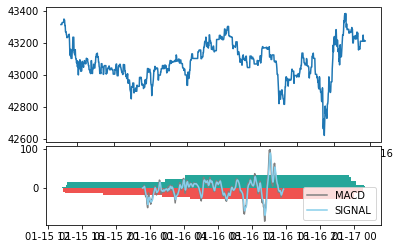

In [118]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['close'], df['macd'], df['signal'], df['hist'])


In [78]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(df['close'], df)

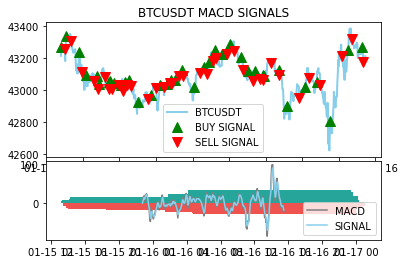

In [79]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['close'], color = 'skyblue', linewidth = 2, label = str(coin))
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title(str(coin+" MACD SIGNALS"))
ax2.plot(df['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(df['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(df)):
    if str(df['hist'][i])[0] == '-':
        ax2.bar(df.index[i], df['hist'][i], color = '#ef5350')
    else:
        ax2.bar(df.index[i], df['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()


In [ ]:
macd_signal

In [82]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = df['macd']
signal = df['signal']
close_price = df['close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(df.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,macd,signal,macd_signal,macd_position
dateTime,,,,,
2022-01-15 22:48:00,43213.86,0.000000,0.000000,0,1
2022-01-15 22:49:00,43267.36,4.267806,0.853561,1,1
2022-01-15 22:50:00,43267.51,7.574859,2.197821,0,1
2022-01-15 22:51:00,43267.51,10.079531,3.774163,0,1
2022-01-15 22:52:00,43262.86,11.556075,5.330545,0,1
...,...,...,...,...,...
2022-01-16 15:23:00,43175.67,-19.306060,-12.440014,0,0
2022-01-16 15:24:00,43163.90,-21.297095,-14.211430,0,0
2022-01-16 15:25:00,43160.57,-22.879962,-15.945137,0,0


# RSI - Relative Strength Index

In [96]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df['rsi_14'] = get_rsi(df['close'], 14)
df = df.dropna()


In [119]:
df

,open,high,low,close,volume,rsi_14,macd,signal,hist
dateTime,,,,,,,,,
2022-01-15 23:08:00,43315.95,43315.95,43315.95,43315.95,0.019700,96.211940,0.000000,0.000000,0.000000
2022-01-15 23:09:00,43315.95,43315.95,43315.95,43315.95,0.000000,96.211940,0.000000,0.000000,0.000000
2022-01-15 23:10:00,43315.95,43315.95,43315.95,43315.95,0.000000,96.211940,0.000000,0.000000,0.000000
2022-01-15 23:11:00,43315.95,43315.95,43315.95,43315.95,0.000000,96.211940,0.000000,0.000000,0.000000
2022-01-15 23:12:00,43316.81,43332.56,43316.81,43328.11,0.798471,96.312907,0.970028,0.194006,0.776023
...,...,...,...,...,...,...,...,...,...
2022-01-16 15:39:00,43217.90,43217.90,43217.90,43217.90,0.014060,50.727205,-1.264013,-5.085569,3.821556
2022-01-16 15:40:00,43214.72,43214.84,43214.72,43214.84,0.018460,49.790759,-1.098182,-4.288091,3.189909
2022-01-16 15:41:00,43212.83,43213.14,43212.83,43213.14,0.007541,49.246842,-1.091355,-3.648744,2.557389


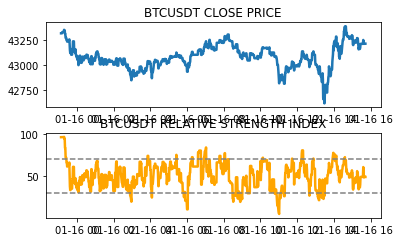

In [97]:
ax3 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax4 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax3.plot(df['close'], linewidth = 2.5)
ax3.set_title(str(coin+" CLOSE PRICE"))
ax4.plot(df['rsi_14'], color = 'orange', linewidth = 2.5)
ax4.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax4.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax4.set_title(str(coin+" RELATIVE STRENGTH INDEX"))
plt.show()

In [98]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

rsi_buy_price, rsi_sell_price, rsi_signal = implement_rsi_strategy(df['close'], df['rsi_14'])

In [99]:
df

,open,high,low,close,volume,rsi_14
dateTime,,,,,,
2022-01-15 23:08:00,43315.95,43315.95,43315.95,43315.95,0.019700,96.211940
2022-01-15 23:09:00,43315.95,43315.95,43315.95,43315.95,0.000000,96.211940
2022-01-15 23:10:00,43315.95,43315.95,43315.95,43315.95,0.000000,96.211940
2022-01-15 23:11:00,43315.95,43315.95,43315.95,43315.95,0.000000,96.211940
2022-01-15 23:12:00,43316.81,43332.56,43316.81,43328.11,0.798471,96.312907
...,...,...,...,...,...,...
2022-01-16 15:39:00,43217.90,43217.90,43217.90,43217.90,0.014060,50.727205
2022-01-16 15:40:00,43214.72,43214.84,43214.72,43214.84,0.018460,49.790759
2022-01-16 15:41:00,43212.83,43213.14,43212.83,43213.14,0.007541,49.246842


In [103]:
print(len(df.index))

996


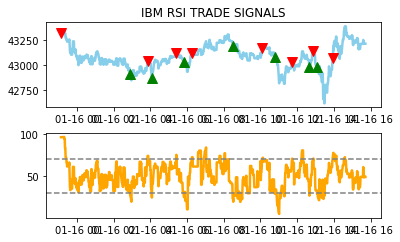

In [107]:
ax5 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax6 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax5.plot(df['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax5.plot(df.index, rsi_buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax5.plot(df.index, rsi_sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax5.set_title('IBM RSI TRADE SIGNALS')
ax6.plot(df['rsi_14'], color = 'orange', linewidth = 2.5)
ax6.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax6.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [94]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = df['rsi_14']
close_price = df['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(df.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,rsi_14,rsi_signal,rsi_position
dateTime,,,,
2022-01-15 22:52:00,43262.86,99.230732,-1,0
2022-01-15 22:53:00,43279.80,99.253268,0,0
2022-01-15 22:54:00,43279.80,99.253268,0,0
2022-01-15 22:55:00,43279.80,99.253268,0,0
2022-01-15 22:56:00,43279.80,99.253268,0,0


# STOCHASTIC OSCILLATOR

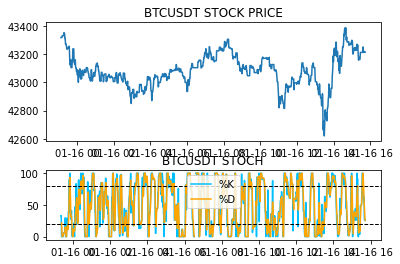

In [109]:

stoch_data = df.copy()

stoch_data['high'] = stoch_data['high'].rolling(14).max()
stoch_data['low'] = stoch_data['low'].rolling(14).min()
stoch_data['%k'] = (stoch_data["close"] - stoch_data['low'])*100/(stoch_data['high'] - stoch_data['low'])
stoch_data['%d'] = stoch_data['%k'].rolling(3).mean()

def plot_stoch(price, k, d):
    ax7 = plt.subplot2grid((9, 1), (0,0), rowspan = 5, colspan = 1)
    ax8 = plt.subplot2grid((9, 1), (6,0), rowspan = 3, colspan = 1)
    ax7.plot(price)
    ax7.set_title(f'{coin} STOCK PRICE')
    ax8.plot(k, color = 'deepskyblue', linewidth = 1.5, label = '%K')
    ax8.plot(d, color = 'orange', linewidth = 1.5, label = '%D')
    ax8.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
    ax8.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
    ax8.set_title(f'{coin} STOCH')
    ax8.legend()
    plt.show()
    
plot_stoch(df['close'], stoch_data['%k'], stoch_data['%d'])

In [111]:
def implement_stoch_strategy(prices, k, d):    
    buy_price = []
    sell_price = []
    stoch_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 20 and d[i] < 20 and k[i] < d[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        elif k[i] > 80 and d[i] > 80 and k[i] > d[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_signal.append(0)
            
    return buy_price, sell_price, stoch_signal
            
stoch_buy_price, stoch_sell_price, stoch_signal = implement_stoch_strategy(stoch_data['close'], stoch_data['%k'], stoch_data['%d'])

In [112]:
position = []
for i in range(len(stoch_signal)):
    if stoch_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(stoch_data['close'])):
    if stoch_signal[i] == 1:
        position[i] = 1
    elif stoch_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
k = stoch_data['%k']
d = stoch_data['%d']
close_price = stoch_data['close']
stoch_signal = pd.DataFrame(stoch_signal).rename(columns = {0:'stoch_signal'}).set_index(stoch_data.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_position'}).set_index(stoch_data.index)

frames = [close_price, k, d, stoch_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.tail()

,close,%k,%d,stoch_signal,stoch_position
dateTime,,,,,
2022-01-16 15:39:00,43217.90,62.451749,58.846994,0,0
2022-01-16 15:40:00,43214.84,29.027049,49.211483,0,0
2022-01-16 15:41:00,43213.14,25.595478,39.024759,0,0
2022-01-16 15:42:00,43213.14,25.595478,26.739335,0,0
2022-01-16 15:43:00,43213.14,25.595478,25.595478,0,0
